In [1]:
# Dependencies
import json
import modules.dataset.entities as en
import modules.dataset.tweets as tw
import matplotlib.pyplot as plt

%matplotlib inline

# Constants
years = [2018, 2019]

# Dataset creation

Once words and hashtags are extracted, they are stored in Pandas DataFrames with the following attributes:

1. <code> id </code> : Reference to the tweet ID
2. <code> index </code> : Position of the word in the sentence (tweet) - useful to delete self loops (WORDS ONLY)
3. <code> text </code> : Text
4. <code> pos </code> : Part Of Speech tag (WORDS ONLY)
5. <code> conf </code> : Confidence associated to the POS tag (WORDS ONLY)

In [2]:
# Initialize Tweets class
tweets = tw.Tweets()
# Fill tweets dataframe
tweets.from_json('data/db/tweets_climatechange.json')
# Rename columns
tweets.df = tweets.df.rename(columns = {'id': 'tweet_id','created_at': 'tweet_date','text': 'tweet_text'})
tweets.df.head()

,tweet_date,tweet_id,tweet_text,hashtags,retweet_count,favorite_count,original_retweet_count,original_favorite
0,2018-04-23 02:23:27,988241915412873216,#GlobalWarming is one aspect of #ClimateChange...,"[globalwarming, climatechange, earthday]",0,0,40.0,57.0
1,2018-04-23 02:23:35,988241946073321472,We are still breaking the wrong records! Heat ...,"[climatechange, climateaction]",0,0,41.0,31.0
2,2018-04-23 02:24:03,988242065199943680,We responded to questions about the #Maskbook ...,"[maskbook, airpollution, climatechange, artofc...",0,0,11.0,12.0
3,2018-04-23 02:24:11,988242096812380160,"On this #EarthDay, we celebrate our members an...","[earthday, climateaction, climatechange, globa...",0,0,17.0,47.0
4,2018-04-23 02:24:11,988242096812380160,"On this #EarthDay, we celebrate our members an...","[earthday, climateaction, climatechange, globa...",0,0,17.0,47.0


In [3]:
# Initialize substitution dictionary
subs = {}
# Load hahstag substitutions
with open('data/hashtag_subs.json', 'r') as file:
    subs = {**subs, **json.load(file)}
# Load contact forms substitutions
with open('data/contract_forms.json', 'r') as file:
    subs = {**subs, **json.load(file)}

In [4]:
# Get hashtags and words datasets
hashtags, words = tweets.get_entities(subs=subs)
hashtags.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
0,988241915412873216,0,#globalwarming,#,0.6281
5,988241915412873216,5,#climatechange,N,0.4957
22,988241915412873216,22,#earthday,#,0.9414
46,988241946073321472,23,#climatechange,#,0.9188
47,988241946073321472,24,#climateaction,#,0.9933


In [5]:
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
0,988241915412873216,0,is,V,0.9904
1,988241915412873216,1,one,$,0.7817
2,988241915412873216,2,aspect,N,0.9988
3,988241915412873216,3,of,P,0.9966
4,988241915412873216,4,#climatechange,N,0.4957


In [6]:
# Save hashtags data
hashtags.to_json('data/db/hashtags.json')
#words.to_json('data/db/words.json')

## Words filtering

In [7]:
# Filter on POS tag
words.df = words.df[words.df.entity_tag.isin(['N', 'V', 'R', 'A', 'O', 'S'])]
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
0,988241915412873216,0,is,V,0.9904
2,988241915412873216,2,aspect,N,0.9988
4,988241915412873216,4,#climatechange,N,0.4957
7,988241915412873216,7,working,V,0.9958
9,988241915412873216,9,tackle,V,0.9997


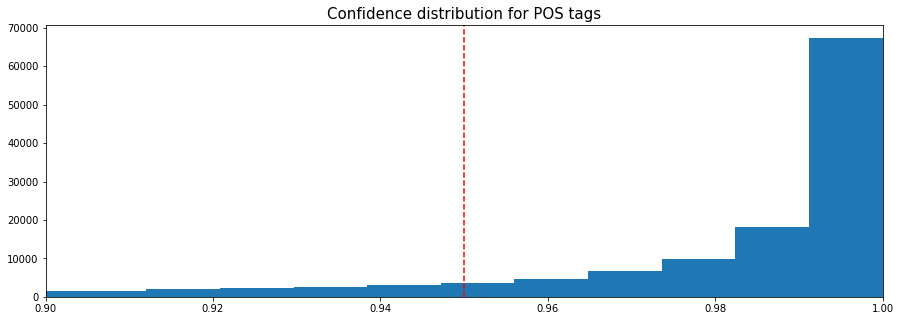

There are 46011 (29.57%) words under 0.95 confidence interval
There will be 109591 (70.43%) words remaining inside 0.95 confidence interval


In [8]:
# Set threshold on confidence
conf = 0.95

# Show confidence distribution
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Confidence distribution for POS tags',fontsize=15)
_ = ax.hist(words.df.entity_conf, bins=100)
_ = ax.set_xlim(left=0.9, right=1.0)
_ = ax.axvline(x=conf, c='r', ls='--')
# _ = plt.savefig('images/preprocessing/tag_conf.png')
_ = plt.show()

# info
print('There are {:d} ({:.02f}%) words under {:.2f} confidence interval'.format(
    sum(words.df.entity_conf < conf), sum(words.df.entity_conf < conf) / words.df.shape[0] * 100, conf
))
# info
print('There will be {:d} ({:.02f}%) words remaining inside {:.2f} confidence interval'.format(
    sum(words.df.entity_conf >= conf), sum(words.df.entity_conf >= conf) / words.df.shape[0] * 100, conf
))

In [9]:
# Filter on confidence
words.df = words.df[words.df.entity_conf >= conf]

## Words cleaning

In [10]:
words.clean_entities()
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
2,988241915412873216,2,aspect,N,0.9988
7,988241915412873216,7,working,V,0.9958
9,988241915412873216,9,tackle,V,0.9997
11,988241915412873216,11,climate,N,0.9865
12,988241915412873216,12,crisis,N,0.9973
